In [1]:
import os
from glob import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Activation, Dropout,Conv2DTranspose
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.optimizers import Adam
from IPython import display
from tqdm.auto import tqdm


C:\Users\jpolo\anaconda3\envs\tf2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_folder = "data/images"
mask_folder = "data/masks"
image_size = (256, 256)

# Find all image file paths recursively in the image folder
image_paths = glob(os.path.join(image_folder, "**/*.png"), recursive=True)

# Read and process the images
images = []
for image_path in image_paths:
    image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size, interpolation=cv2.INTER_NEAREST)
    image = (image - 127.5) / 127.5
    image=image.astype(np.float32)
    images.append(image)

# Convert the images list to a NumPy array
input_images = np.array(images)

# Verify the shape of the images array
print("Shape of images array:", input_images.shape)

Shape of images array: (1060, 256, 256, 3)


In [3]:
input_images.dtype

dtype('float32')

In [4]:
# Find all mask file paths recursively in the mask folder
mask_paths = glob(os.path.join(mask_folder, "**/*.png"), recursive=True)

# Read and process the masks
masks = []
for mask_path in mask_paths:
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    mask = (mask - 127.5) / 127.5
    mask=mask.astype(np.float32)
    masks.append(mask)

# Convert the masks list to a NumPy array
target_images = np.array(masks)

# Verify the shape of the masks array
print("Shape of masks array:", target_images.shape)

Shape of masks array: (1060, 256, 256, 3)


In [5]:
target_images.dtype

dtype('float32')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

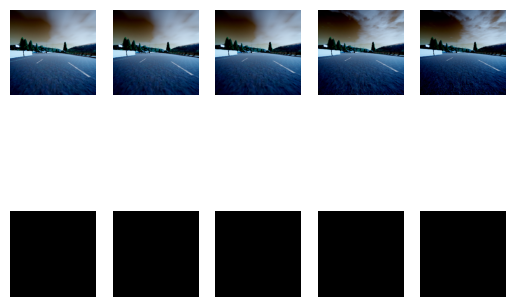

In [6]:
n_samples = 5
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(input_images[i])
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(target_images[i])
plt.show()

In [7]:
#np.unique(masks_array)

In [8]:
#num_classes = 23  # Total number of classes, including the background

# Perform one-hot encoding on the masks
#masks_encoded = np.zeros((masks_array.shape[0], masks_array.shape[1], masks_array.shape[2], num_classes), dtype=np.float32)
#for class_label in range(num_classes):
    #masks_encoded[..., class_label] = np.all(masks_array == class_label, axis=-1)


# Verify the shape of the one-hot encoded masks
#print("Shape of one-hot encoded masks:", masks_encoded.shape)


In [9]:
#masks_encoded

In [10]:
# Create TensorFlow dataset on CPU
with tf.device('/CPU:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1060).batch(1)

# Print the number of samples in the training dataset
print("Number of samples in the training dataset:", len(train_dataset))

Number of samples in the training dataset: 1060


In [11]:
####Define the Discriminator
###The 70 × 70 discriminator architecture is:
###C64-C128-C256-C512
### PatchGAN is implemented by this equation:
### (out_dim -1)*s= input_dim -k

def build_discriminator():
    source_image= Input(shape=(256, 256, 3))
    target_image= Input(shape=(256, 256, 3))
    
    cat= Concatenate()([source_image, target_image]) ## this makes the Gan conditional
    d= Conv2D(64, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(cat)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(128, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(256, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    
    d=Conv2D(512, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    d= BatchNormalization()(d)
    d=LeakyReLU(0.2)(d)
    
    d=Conv2D(1, kernel_size=4, strides=1, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d)
    
    d= Activation("sigmoid")(d)
    return Model([source_image, target_image], d)

In [12]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [13]:
def encoder_block(inputs, filters, batchnorm=True):
    g= Conv2D(filters, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(inputs)
    if batchnorm:
        g= BatchNormalization()(g)
                                
    g= LeakyReLU(0.2)(g)
    return g

In [14]:
def decoder_block(inputs, skips, filters, dropout=True):
    g= Conv2DTranspose(filters, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(inputs)
    g= BatchNormalization()(g)
                                
    
    if dropout:
        g=Dropout(0.5)(g)
        
    g= Concatenate()([g, skips])
    g= Activation("relu")(g)
    return g    

In [15]:
def build_generator():
    input_image=Input(shape=(256, 256, 3))
    
    d1= encoder_block(input_image, 64, batchnorm=False) #128
    d2= encoder_block(d1, 128) #64
    d3= encoder_block(d2, 256) #32
    d4= encoder_block(d3, 512) #16
    d5= encoder_block(d4, 512) #8
    d6= encoder_block(d5, 512) #4
    d7= encoder_block(d6, 512) #2
    
    bottleneck= Conv2D(512, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False)(d7) #1
    bottleneck=Activation("relu")(bottleneck)
    
    u1= decoder_block(bottleneck, d7, 512) #2
    u2 = decoder_block(u1, d6, 512) #4
    u3= decoder_block(u2, d5, 512) #8
    u4= decoder_block(u3, d4, 512, dropout=False)#16
    u5= decoder_block(u4, d3, 256, dropout=False)#32
    u6= decoder_block(u5, d2, 128, dropout=False)#64
    u7= decoder_block(u6, d1, 64,dropout=False)#128
    
    final_conv= Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(u7)###256
    
    out= Activation("tanh")(final_conv)
    return Model(input_image, out)
    
    
    

In [16]:
generator = build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_5[0][0]']               
                                )                                                           

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 8, 8, 512)   8388608     ['activation_3[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_11 (BatchN  (None, 8, 8, 512)   2048        ['conv2d_transpose_2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 dropout_2 (Dropout)            (None, 8, 8, 512)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 8, 8, 1024)   0           ['dropout_2[0][0]',              
          

In [17]:
# Define loss function
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [18]:
# Generator loss
def generator_loss(disc_generated_output, generated_images, target):
    gan_loss = binary_cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - generated_images))
    total_gen_loss = gan_loss + (100 * l1_loss)  # Lambda parameter balances the two losses

    return total_gen_loss

In [19]:
# Discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = binary_cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = binary_cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = 0.5*(real_loss + fake_loss)

    return total_disc_loss

In [20]:
# Instantiate generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

In [21]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)

In [22]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image
        generated_images = generator(input_image, training=True)

        # Discriminator outputs
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, generated_images], training=True)

        # Calculate losses
        gen_total_loss = generator_loss(disc_generated_output, generated_images, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate gradients
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return gen_total_loss, disc_loss

In [23]:
num_epochs=100

In [24]:
# Training loop
for epoch in range(num_epochs):
    print("Epoch:", epoch)

    progress_bar = tqdm(train_dataset, desc=f'Epoch {epoch}/{num_epochs}', unit='batch')

    for batch, (input_images, target_images) in enumerate(progress_bar):
        gen_loss, disc_loss = train_step(input_images, target_images)

        # Print losses for progress monitoring
        progress_bar.set_postfix({'Generator Loss': gen_loss.numpy(), 'Discriminator Loss': disc_loss.numpy()})

Epoch: 0


Epoch 0/100:   0%|          | 0/1060 [00:00<?, ?batch/s]C:\Users\jpolo\anaconda3\envs\tf2\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Epoch 0/100: 100%|██████████| 1060/1060 [01:37<00:00, 10.84batch/s, Generator Loss=1.19, Discriminator Loss=0.709] 


Epoch: 1


Epoch 1/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.80batch/s, Generator Loss=1.34, Discriminator Loss=0.667] 


Epoch: 2


Epoch 2/100: 100%|██████████| 1060/1060 [01:30<00:00, 11.76batch/s, Generator Loss=0.905, Discriminator Loss=0.701]


Epoch: 3


Epoch 3/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.86batch/s, Generator Loss=1.14, Discriminator Loss=0.664] 


Epoch: 4


Epoch 4/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.74, Discriminator Loss=0.582] 


Epoch: 5


Epoch 5/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=1.65, Discriminator Loss=0.678] 


Epoch: 6


Epoch 6/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=0.954, Discriminator Loss=0.461]


Epoch: 7


Epoch 7/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.27, Discriminator Loss=0.496] 


Epoch: 8


Epoch 8/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.86batch/s, Generator Loss=1.46, Discriminator Loss=0.706] 


Epoch: 9


Epoch 9/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.31, Discriminator Loss=0.514] 


Epoch: 10


Epoch 10/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=0.84, Discriminator Loss=0.545] 


Epoch: 11


Epoch 11/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.55, Discriminator Loss=0.444] 


Epoch: 12


Epoch 12/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.59, Discriminator Loss=0.484] 


Epoch: 13


Epoch 13/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.89, Discriminator Loss=0.534] 


Epoch: 14


Epoch 14/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.17, Discriminator Loss=0.452] 


Epoch: 15


Epoch 15/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.98, Discriminator Loss=0.491] 


Epoch: 16


Epoch 16/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.43, Discriminator Loss=0.331] 


Epoch: 17


Epoch 17/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.89batch/s, Generator Loss=1.7, Discriminator Loss=0.603]  


Epoch: 18


Epoch 18/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.16, Discriminator Loss=0.531] 


Epoch: 19


Epoch 19/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.29, Discriminator Loss=0.688] 


Epoch: 20


Epoch 20/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.99, Discriminator Loss=0.465] 


Epoch: 21


Epoch 21/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=1.48, Discriminator Loss=0.672] 


Epoch: 22


Epoch 22/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.86, Discriminator Loss=0.754] 


Epoch: 23


Epoch 23/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.89batch/s, Generator Loss=2.43, Discriminator Loss=0.502] 


Epoch: 24


Epoch 24/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=0.788, Discriminator Loss=0.627]


Epoch: 25


Epoch 25/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.89batch/s, Generator Loss=1.67, Discriminator Loss=0.397] 


Epoch: 26


Epoch 26/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=1.55, Discriminator Loss=0.276] 


Epoch: 27


Epoch 27/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.94batch/s, Generator Loss=1.44, Discriminator Loss=0.476] 


Epoch: 28


Epoch 28/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.02batch/s, Generator Loss=2.6, Discriminator Loss=0.218]  


Epoch: 29


Epoch 29/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.03batch/s, Generator Loss=2.14, Discriminator Loss=0.303] 


Epoch: 30


Epoch 30/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.04batch/s, Generator Loss=2.76, Discriminator Loss=0.16]  


Epoch: 31


Epoch 31/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.03batch/s, Generator Loss=2.03, Discriminator Loss=0.336] 


Epoch: 32


Epoch 32/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.00batch/s, Generator Loss=2.04, Discriminator Loss=0.246] 


Epoch: 33


Epoch 33/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.81batch/s, Generator Loss=1.48, Discriminator Loss=0.416] 


Epoch: 34


Epoch 34/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.80batch/s, Generator Loss=1.34, Discriminator Loss=0.416]


Epoch: 35


Epoch 35/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.86batch/s, Generator Loss=1.24, Discriminator Loss=0.475] 


Epoch: 36


Epoch 36/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.81batch/s, Generator Loss=1.92, Discriminator Loss=0.288] 


Epoch: 37


Epoch 37/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.83batch/s, Generator Loss=2.81, Discriminator Loss=0.306] 


Epoch: 38


Epoch 38/100: 100%|██████████| 1060/1060 [01:30<00:00, 11.75batch/s, Generator Loss=1.61, Discriminator Loss=0.324] 


Epoch: 39


Epoch 39/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.86batch/s, Generator Loss=1.16, Discriminator Loss=0.64]  


Epoch: 40


Epoch 40/100: 100%|██████████| 1060/1060 [01:30<00:00, 11.72batch/s, Generator Loss=2.31, Discriminator Loss=0.267] 


Epoch: 41


Epoch 41/100: 100%|██████████| 1060/1060 [01:30<00:00, 11.77batch/s, Generator Loss=1.78, Discriminator Loss=0.306] 


Epoch: 42


Epoch 42/100: 100%|██████████| 1060/1060 [01:30<00:00, 11.77batch/s, Generator Loss=2.75, Discriminator Loss=0.162] 


Epoch: 43


Epoch 43/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.83batch/s, Generator Loss=1.06, Discriminator Loss=0.528] 


Epoch: 44


Epoch 44/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.81batch/s, Generator Loss=1.78, Discriminator Loss=0.398] 


Epoch: 45


Epoch 45/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.83batch/s, Generator Loss=1.96, Discriminator Loss=0.399] 


Epoch: 46


Epoch 46/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=3.83, Discriminator Loss=0.346] 


Epoch: 47


Epoch 47/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=2.97, Discriminator Loss=0.508] 


Epoch: 48


Epoch 48/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.95batch/s, Generator Loss=1.71, Discriminator Loss=0.586] 


Epoch: 49


Epoch 49/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.95batch/s, Generator Loss=1.78, Discriminator Loss=0.434] 


Epoch: 50


Epoch 50/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.81batch/s, Generator Loss=1.66, Discriminator Loss=0.307] 


Epoch: 51


Epoch 51/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.79batch/s, Generator Loss=2.42, Discriminator Loss=0.336] 


Epoch: 52


Epoch 52/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.94batch/s, Generator Loss=2.13, Discriminator Loss=0.639] 


Epoch: 53


Epoch 53/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.93batch/s, Generator Loss=2.41, Discriminator Loss=0.332] 


Epoch: 54


Epoch 54/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.83batch/s, Generator Loss=2.66, Discriminator Loss=0.131] 


Epoch: 55


Epoch 55/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=3.24, Discriminator Loss=0.335] 


Epoch: 56


Epoch 56/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.94batch/s, Generator Loss=2.32, Discriminator Loss=0.355] 


Epoch: 57


Epoch 57/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.79batch/s, Generator Loss=2.93, Discriminator Loss=0.214] 


Epoch: 58


Epoch 58/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.86batch/s, Generator Loss=4.61, Discriminator Loss=1.29]  


Epoch: 59


Epoch 59/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.87batch/s, Generator Loss=3.82, Discriminator Loss=0.124] 


Epoch: 60


Epoch 60/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.96batch/s, Generator Loss=1.22, Discriminator Loss=0.322] 


Epoch: 61


Epoch 61/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.85batch/s, Generator Loss=0.593, Discriminator Loss=0.7]  


Epoch: 62


Epoch 62/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.93batch/s, Generator Loss=2.38, Discriminator Loss=0.895] 


Epoch: 63


Epoch 63/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.92batch/s, Generator Loss=4.04, Discriminator Loss=1.71]  


Epoch: 64


Epoch 64/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.78batch/s, Generator Loss=2.25, Discriminator Loss=0.353] 


Epoch: 65


Epoch 65/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=3.18, Discriminator Loss=0.117] 


Epoch: 66


Epoch 66/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=1.74, Discriminator Loss=0.637] 


Epoch: 67


Epoch 67/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=4.46, Discriminator Loss=0.264] 


Epoch: 68


Epoch 68/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=4.04, Discriminator Loss=0.398] 


Epoch: 69


Epoch 69/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=1.72, Discriminator Loss=0.397] 


Epoch: 70


Epoch 70/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=1.42, Discriminator Loss=0.454] 


Epoch: 71


Epoch 71/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=2.07, Discriminator Loss=0.367] 


Epoch: 72


Epoch 72/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.93batch/s, Generator Loss=1.19, Discriminator Loss=0.776] 


Epoch: 73


Epoch 73/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.89batch/s, Generator Loss=5.09, Discriminator Loss=0.0737]


Epoch: 74


Epoch 74/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=0.957, Discriminator Loss=0.414]


Epoch: 75


Epoch 75/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.97batch/s, Generator Loss=1.84, Discriminator Loss=0.265] 


Epoch: 76


Epoch 76/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=4.36, Discriminator Loss=0.119] 


Epoch: 77


Epoch 77/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=3, Discriminator Loss=0.323]    


Epoch: 78


Epoch 78/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=3.18, Discriminator Loss=0.892] 


Epoch: 79


Epoch 79/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=3.5, Discriminator Loss=0.135]  


Epoch: 80


Epoch 80/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=3.92, Discriminator Loss=0.0852]


Epoch: 81


Epoch 81/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.95batch/s, Generator Loss=3.13, Discriminator Loss=0.166] 


Epoch: 82


Epoch 82/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.04batch/s, Generator Loss=1.63, Discriminator Loss=0.368] 


Epoch: 83


Epoch 83/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.01batch/s, Generator Loss=3.47, Discriminator Loss=0.0528]


Epoch: 84


Epoch 84/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.03batch/s, Generator Loss=1.99, Discriminator Loss=0.247] 


Epoch: 85


Epoch 85/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=2.78, Discriminator Loss=0.163] 


Epoch: 86


Epoch 86/100: 100%|██████████| 1060/1060 [01:27<00:00, 12.05batch/s, Generator Loss=6.84, Discriminator Loss=0.0703]


Epoch: 87


Epoch 87/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.03batch/s, Generator Loss=3.24, Discriminator Loss=0.236] 


Epoch: 88


Epoch 88/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.93batch/s, Generator Loss=3.51, Discriminator Loss=0.09]  


Epoch: 89


Epoch 89/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.88batch/s, Generator Loss=9.43, Discriminator Loss=0.0144]


Epoch: 90


Epoch 90/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.00batch/s, Generator Loss=3.55, Discriminator Loss=1.07]  


Epoch: 91


Epoch 91/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.03batch/s, Generator Loss=2.35, Discriminator Loss=0.298] 


Epoch: 92


Epoch 92/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=4.49, Discriminator Loss=0.116] 


Epoch: 93


Epoch 93/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.04batch/s, Generator Loss=1.46, Discriminator Loss=0.378] 


Epoch: 94


Epoch 94/100: 100%|██████████| 1060/1060 [01:29<00:00, 11.90batch/s, Generator Loss=7.5, Discriminator Loss=0.119]  


Epoch: 95


Epoch 95/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.98batch/s, Generator Loss=1.19, Discriminator Loss=0.511] 


Epoch: 96


Epoch 96/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.97batch/s, Generator Loss=1.24, Discriminator Loss=0.729] 


Epoch: 97


Epoch 97/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.96batch/s, Generator Loss=5.03, Discriminator Loss=0.0426]


Epoch: 98


Epoch 98/100: 100%|██████████| 1060/1060 [01:28<00:00, 12.01batch/s, Generator Loss=2.37, Discriminator Loss=0.365] 


Epoch: 99


Epoch 99/100: 100%|██████████| 1060/1060 [01:28<00:00, 11.99batch/s, Generator Loss=1.32, Discriminator Loss=0.299] 


In [25]:
# Save the trained generator model
from keras.models import save_model
from tensorflow.keras.models import load_model
# Save the trained generator model
generator.save("generator100")
# Save the trained discriminator model
discriminator.save("discriminator100")

INFO:tensorflow:Assets written to: generator100\assets


INFO:tensorflow:Assets written to: generator100\assets


INFO:tensorflow:Assets written to: discriminator100\assets


INFO:tensorflow:Assets written to: discriminator100\assets
